In [1]:
print_imports()

Loaded modules:
numpy                np              1.14.0
pandas               pd              0.22.0
sklearn              sk              0.19.1
keras                ks              2.1.4

matplotlib           mpl             2.1.2
matplotlib.pyplot    plt             N/A
matplotlib.image     mpimg           N/A
seaborn              sns             0.8.1
PIL                  PIL             5.0.0

ExergyUtilities      exergy          2.0.

pyspark              pyspark         2.2.1


In [2]:
print(sk)

<module 'sklearn' from '/home/batman/anaconda3/lib/python3.6/site-packages/sklearn/__init__.py'>


In [3]:
import pandas as pd

### Data Loading

In [4]:
dfList = []
for i in range(1,32):
    print(".",end='', flush=True)
    dfList.append(pd.read_json("./data/fraud-data/2017-01-{0:02d}.txt".format(i), lines=True))
print("done!")
df = pd.concat(dfList)

...............................done!


In [5]:
print(df.fraudLabel.value_counts())
df.head()

0    30075
1      925
Name: fraudLabel, dtype: int64


,basket,customerID,fraudLabel,totalAmount,zipCode
0,"[1, 0, 3, 2, 3, 0, 3]",3479993074,0,287,25378
1,"[0, 4, 2]",9867234339,0,30,63929
2,[4],9722892914,0,75,97373
3,"[0, 2, 3, 0, 1, 3]",3473098263,0,732,95113
4,"[1, 4, 3]",5789310347,1,390,84278


### Feature Engineering

Basket to seperate columns

In [6]:
df['c_0'] = df.basket.map(lambda x: x.count(0))
df['c_1'] = df.basket.map(lambda x: x.count(1))
df['c_2'] = df.basket.map(lambda x: x.count(2))
df['c_3'] = df.basket.map(lambda x: x.count(3))
df['c_4'] = df.basket.map(lambda x: x.count(4))

In [7]:
df.head()

,basket,customerID,fraudLabel,totalAmount,zipCode,c_0,c_1,c_2,c_3,c_4
0,"[1, 0, 3, 2, 3, 0, 3]",3479993074,0,287,25378,2,1,1,3,0
1,"[0, 4, 2]",9867234339,0,30,63929,1,0,1,0,1
2,[4],9722892914,0,75,97373,0,0,0,0,1
3,"[0, 2, 3, 0, 1, 3]",3473098263,0,732,95113,2,1,1,2,0
4,"[1, 4, 3]",5789310347,1,390,84278,0,1,0,1,1


Zip code to one-hot

In [8]:
%%script false
#df["zipCode"] = df["zipCode"].astype('category',categories=[i for i in list(range(10000,100000))])
dummies = pd.get_dummies(df.zipCode)

In [9]:
%%script false
dummies.head()

In [10]:
#df2 = pd.concat([df, dummies], axis=1)
df2 = pd.concat([df], axis=1)

In [11]:
#df3 = df2.drop(["basket", "zipCode", "customerID"], axis=1)
df3 = df2.drop(["basket", "customerID"], axis=1)

In [12]:
df3.head()

,fraudLabel,totalAmount,zipCode,c_0,c_1,c_2,c_3,c_4
0,0,287,25378,2,1,1,3,0
1,0,30,63929,1,0,1,0,1
2,0,75,97373,0,0,0,0,1
3,0,732,95113,2,1,1,2,0
4,1,390,84278,0,1,0,1,1


### Model training

In [13]:
from sklearn.model_selection import train_test_split
train, test = sk.model_selection.train_test_split(df3, test_size=0.3, random_state=0)
train.head()

,fraudLabel,totalAmount,zipCode,c_0,c_1,c_2,c_3,c_4
281,0,1248,27552,1,2,2,5,2
57,0,120,15856,0,1,3,0,1
273,0,130,65290,0,0,3,1,1
725,0,146,25083,0,1,0,1,0
55,1,116,96166,0,0,0,2,0


Save to csv

In [14]:
%%script false
# save predictions to csv
train.to_pickle("./data/train.pickle")
test.to_pickle("./data/test.pickle")

Create X and y

In [15]:
X_train = train[train.columns[1:]]
y_train = train["fraudLabel"]
X_test = test[test.columns[1:]]
y_test = test["fraudLabel"]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(21700, 7) (21700,) (9300, 7) (9300,)


Logistic regresssion

In [16]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

balanced logistic regresion

In [17]:
from sklearn.linear_model import LogisticRegression
logreg_bal = LogisticRegression(class_weight='balanced')
logreg_bal.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Gradient Boosted Trees

In [18]:
from sklearn.ensemble import GradientBoostingClassifier
gbt = GradientBoostingClassifier()
gbt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

### Model evaluation

In [19]:
test_scores_reg = logreg.predict_proba(X_test)
test_scores_gbt = gbt.predict_proba(X_test)
test_scores_reg_bal = logreg_bal.predict_proba(X_test)

In [20]:
from sklearn import metrics
fpr_reg, tpr_reg, _ =  sk.metrics.roc_curve(y_test, test_scores_reg[:,1])
auc_reg = metrics.auc(fpr_reg, tpr_reg)
fpr_gbt, tpr_gbt, _ =  sk.metrics.roc_curve(y_test, test_scores_gbt[:,1])
auc_gbt = metrics.auc(fpr_gbt, tpr_gbt)

In [21]:
# save predictions to csv
df = pd.DataFrame(data={'label': y_test, 'predReg': test_scores_reg[:,1], 
                  'predGbt': test_scores_gbt[:,1] })
df.to_csv("./data/predictions.csv", index=False)

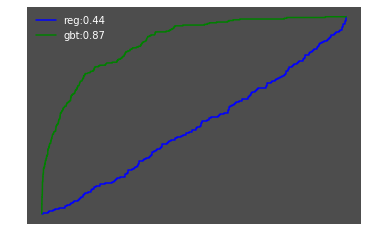

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_reg, tpr_reg, color = 'blue', label = "reg:{:.2f}".format(auc_reg))
plt.plot(fpr_gbt, tpr_gbt, color = 'green', label = "gbt:{:.2f}".format(auc_gbt))
plt.legend()
plt.grid()
plt.show()

### Save predictions on train data for modelCalibration

In [23]:
train_scores_reg = logreg.predict_proba(X_train)
train_scores_gbt = gbt.predict_proba(X_train)

In [24]:
# save predictions to csv
df = pd.DataFrame(data={'label': y_train, 'predReg': train_scores_reg[:,1], 
                  'predGbt': train_scores_gbt[:,1] })
#df.to_csv("./data/predictions_train.csv", index=False)

In [25]:
pd.DataFrame(train_scores_gbt[:,1],y_train)

,0
fraudLabel,
0,0.012370
0,0.004365
0,0.015028
0,0.022796
1,0.110889
0,0.132548
0,0.045539
0,0.002398
0,0.013009


Create sorted pred and y df

In [26]:
gbt_sort = pd.DataFrame({'pred':train_scores_gbt[:,1], 'y':y_train}).reset_index(drop=1)
gbt_sort = gbt_sort.sort_values(by='pred')
gbt_sort.head()
#gbt_sort.dtypes
#pd.DataFrame(train_scores_gbt)

,pred,y
13422,0.000576,0
11229,0.000594,0
14414,0.000611,0
17916,0.000616,0
9930,0.000637,0


In [27]:
def split_df(df, chunkSize = 100): 
    listOfDf = list()
    numberChunks = len(df) // chunkSize + 1
    for i in range(numberChunks):
        listOfDf.append(df[i*chunkSize:(i+1)*chunkSize])
    return listOfDf

In [28]:
bsize = 100
buckets = split_df(gbt_sort, bsize)

In [29]:
len(buckets)

218

In [30]:
cutoff = 0.5
rows = list()
for i,buck in enumerate(buckets[0:-1]):
    #print(buck)
    predicted_prob = np.mean(buck['pred'])/bsize
    real_prob = sum(buck['y'])/bsize
    rows.append([predicted_prob, real_prob])
    #print(i,predicted_prob, real_prob)
    #sum(buck['pred'])
    #print(len(buck['pred']))
    #raise

In [31]:
calibration = pd.DataFrame(rows, columns = ['predicted','real'])
calibration.head()

,predicted,real
0,0.000009,0.0
1,0.000012,0.0
2,0.000014,0.0
3,0.000015,0.0
4,0.000016,0.0


In [32]:
def plot_calibration(calibration):
    fig = plt.figure(figsize=[10,10])
    #calibration.plot(x='real', y='predicted', style='bo',figsize=[10,10])

    plt.scatter(x=calibration['real'],y=calibration['predicted'])
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('Real')
    plt.ylabel('Pred')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

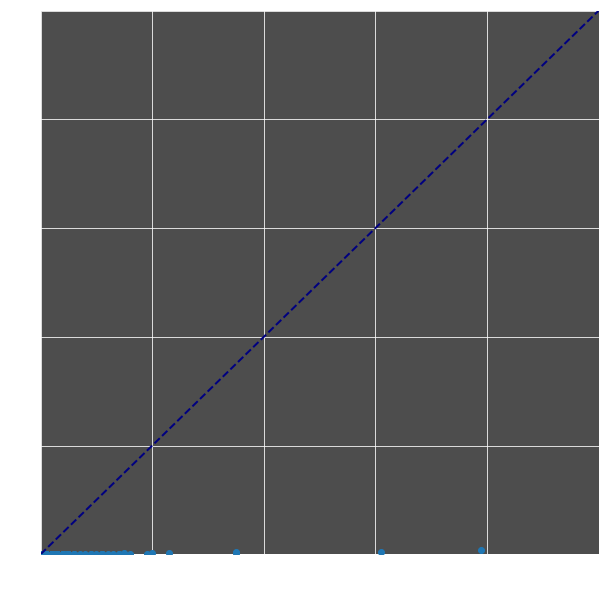

In [33]:
plot_calibration(calibration)